<a href="https://colab.research.google.com/github/tomonari-masada/course2021-stats2/blob/main/04_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. モデリングの例
* 事前分布の決め方が分析結果にどう影響するかを見る。

## 4.1 準備

In [1]:
!pip install arviz==0.10

     |████████████████████████████████| 1.5MB 5.5MB/s 
     |████████████████████████████████| 768kB 20.6MB/s 
     |████████████████████████████████| 4.7MB 33.0MB/s 
     |████████████████████████████████| 317kB 46.0MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


In [2]:
!pip install pymc3==3.10

     |████████████████████████████████| 1.9MB 4.6MB/s 
     |████████████████████████████████| 2.8MB 21.0MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.0.11-cp37-none-any.whl size=2572023 sha256=069e449f6b4316504007fdeae2edc0fb9a6dffe4281c893300c53faa4e29402c
  Stored in directory: /root/.cache/pip/wheels/26/b2/77/4ee2bb9b1c1de7de771254a5e379d898273d8114237b0df686
Successfully built theano-pymc
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [3]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

SEED = [12, 123, 1234, 12345]

## 4.2 Rosenthal and Jacobson (1968) の実験の結果を分析する
* 「統計モデリング1」で紹介だけした。
 * https://github.com/tomonari-masada/course-stats1/blob/master/06_normal_2.pdf
* データは原論文のものではなく、それに似せて作ったもの。
 * [STA 360/602: Bayesian Methods and Modern Statistics @ Duke University](http://www2.stat.duke.edu/~rcs46/bayes17.html)のModule 4より拝借。
* 明らかにしたいこと： 教師が期待をかけるか否かで学生の学修に影響があるか？
 * つまり、$\mathbb{P}(\mu_s > \mu_c | \mathbf{x}_s, \mathbf{x}_c)$を知りたい。
 * $\mathbf{x}_s$: spurters（期待をかけられた学生たち）のIQ変化量データ群
 * $\mathbf{x}_c$: controls（その他の学生たち）のIQ変化量データ群


### 4.2.1 データ
* 数値は、実験開始直前からのIQの変化量を表す。

In [4]:
x_s = [18, 40, 15, 17, 20, 44, 38]
x_c = [-4, 0, -19, 24, 19, 10, 5, 10,
       29, 13, -9, -8, 20, -1, 12, 21,
       -7, 14, 13, 20, 11, 16, 15, 27,
       23, 36, -33, 34, 13, 11, -19, 21,
       6, 25, 30,22, -28, 15, 26, -1, -2,
       43, 23, 22, 25, 16, 10, 29]

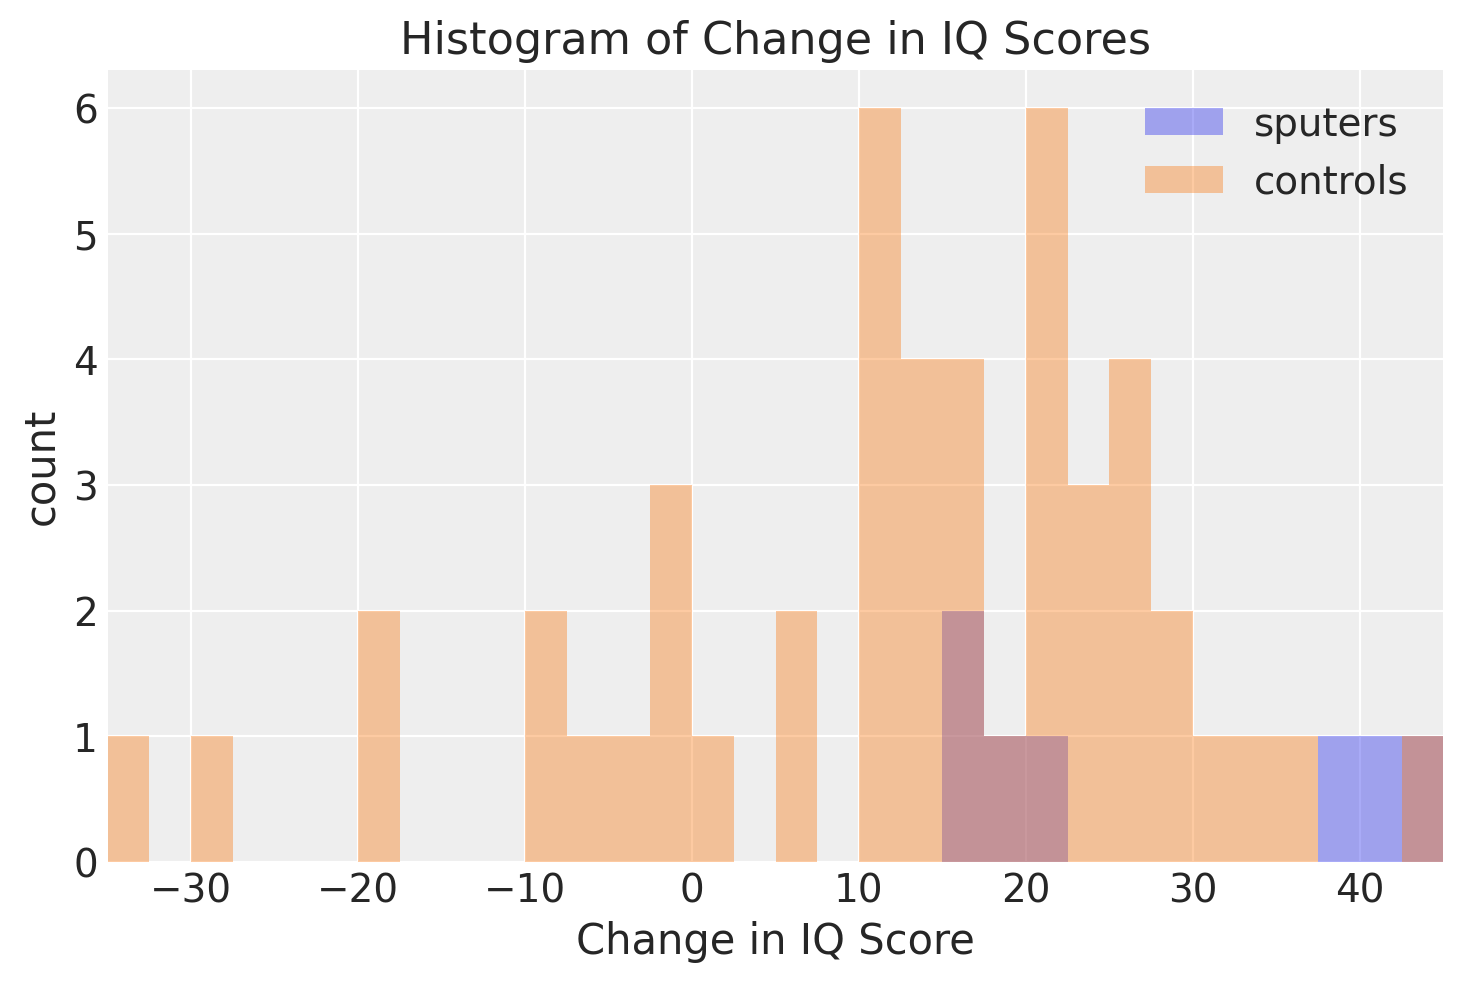

In [5]:
sns.distplot(x_s, kde=False, bins=np.linspace(-35,45,33), label="sputers")
sns.distplot(x_c, kde=False, bins=np.linspace(-35,45,33), label="controls")
plt.xlim(-35, 45)
plt.xlabel('Change in IQ Score')
plt.ylabel('count')
plt.title('Histogram of Change in IQ Scores')
plt.legend()

### 4.2.2 モデル
* 各グループの変化量は異なる正規分布に従うと仮定する。
 * spurtersの変化量のモデル $x_s \sim N(\mu_s, \lambda_s^{-1})$
 * controlsの変化量のモデル $x_c \sim N(\mu_c, \lambda_c^{-1})$
* 各グループの正規分布の平均パラメータは、同じ正規分布に従うと仮定する。
 * つまり $\mu_s, \mu_c \sim N(\mu_0, \sigma_0)$
* 各グループの正規分布の精度（分散の逆数）パラメータは、同じガンマ分布に従うと仮定する。
 * つまり $\lambda_s, \lambda_c \sim \text{Gam}(\alpha, \beta)$
* $N(\mu_0, \sigma_0)$と$\text{Gam}(\alpha, \beta)$が、事前分布。

### 4.2.3 ハイパーパラメータの決め方
* 事前分布のパラメータをハイパーパラメータと呼ぶ。
* 精度パラメータが従うガンマ分布$\text{Gam}(\alpha, \beta)$については、[STA 360/602: Bayesian Methods and Modern Statistics @ Duke University](http://www2.stat.duke.edu/~rcs46/bayes17.html)のModule 4の決め方を踏襲する。
 * $\alpha$は$\frac{1}{2}$とする。
 * $\beta$は$10^2\alpha$とする。
* この設定は、以下の議論で固定しておく。

### 4.2.4 問題
* $\text{Gam}(\alpha, \beta)$のパラメータを上のように決めると、IQの変化量の散らばり具合について、どのように仮定していることになるか？
 * ヒント1： $\text{Gam}(\alpha, \beta)$がモデリングしているのは、精度、つまり、分散の逆数であることに注意しよう。
 * ヒント2： $\text{Gam}(\alpha, \beta)$に従う確率変数の値の平均は$\frac{\alpha}{\beta}$である。

## 4.3 事前分布 (1)
* 平均パラメータが従う正規分布$\mu \sim N(\mu_0, \sigma_0^2)$について・・・



### 4.3.1 事前分布の平均パラメータ$\mu_0$の設定
* 平均パラメータ$\mu_0$は0とする。
 * なぜなら、IQの変化量の平均が、増えるのか、減るのか、全く分からないから。

### 4.3.2 事前分布の分散パラメータ$\sigma_0^2$の設定
* 標準偏差パラメータ$\sigma_0$は1とする。
 * これは、ざっくりどういう意味か？（どういうお気持ちを表しているか？）
* 考察をしやすくするために、観測データが従う正規分布$N(\mu, \sigma^2)$の分散$\sigma^2$を固定する。
* すると、$\mu$の事後分布の分散は$(\frac{1}{\sigma_0^2} + \frac{n}{\sigma^2})^{-1}$となる。
 * $n$は観測データの個数。
* $\sigma_0$を大きくすると、$n$個の観測データで決まる$\frac{n}{\sigma^2}$の項のほうが支配的となる。
* $\sigma_0$を小さくすると、$\frac{1}{\sigma_0^2}$の項のほうが支配的となる。
* $\sigma_0=1$という仮定は、ざっくり言って、これらの中間。
* つまり、IQの変化量の平均がどのくらいバラつくかという不確かさについて、（非常にざっくり言って）事前分布がサンプル一個分と同程度の寄与をする、と仮定している。

### 4.3.3 PyMC3によるモデルの実装

In [6]:
mu_0 = 0.0
sd_0 = 1.0
alpha = 0.5

model = pm.Model()

with model:
    lambda_s = pm.Gamma("lambda_s", alpha=alpha, beta=100*alpha)
    lambda_c = pm.Gamma("lambda_c", alpha=alpha, beta=100*alpha)
    mu_s = pm.Normal("mu_s", mu=mu_0, sigma=sd_0)
    mu_c = pm.Normal("mu_c", mu=mu_0, sigma=sd_0)
    obs_s = pm.Normal("obs_s", mu=mu_s, tau=lambda_s, observed=np.array(x_s))
    obs_c = pm.Normal("obs_c", mu=mu_c, tau=lambda_c, observed=np.array(x_c))

### 4.3.4 MCMCによるベイズ推論
* デフォルトのNUTSサンプラを使う。

In [7]:
with model:
    idata = pm.sample(2000, cores=len(SEED), return_inferencedata=True, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_c, mu_s, lambda_c, lambda_s]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.


### 4.3.5 サンプルのチェック

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faa51bbe0d0>,
      dtype=object)

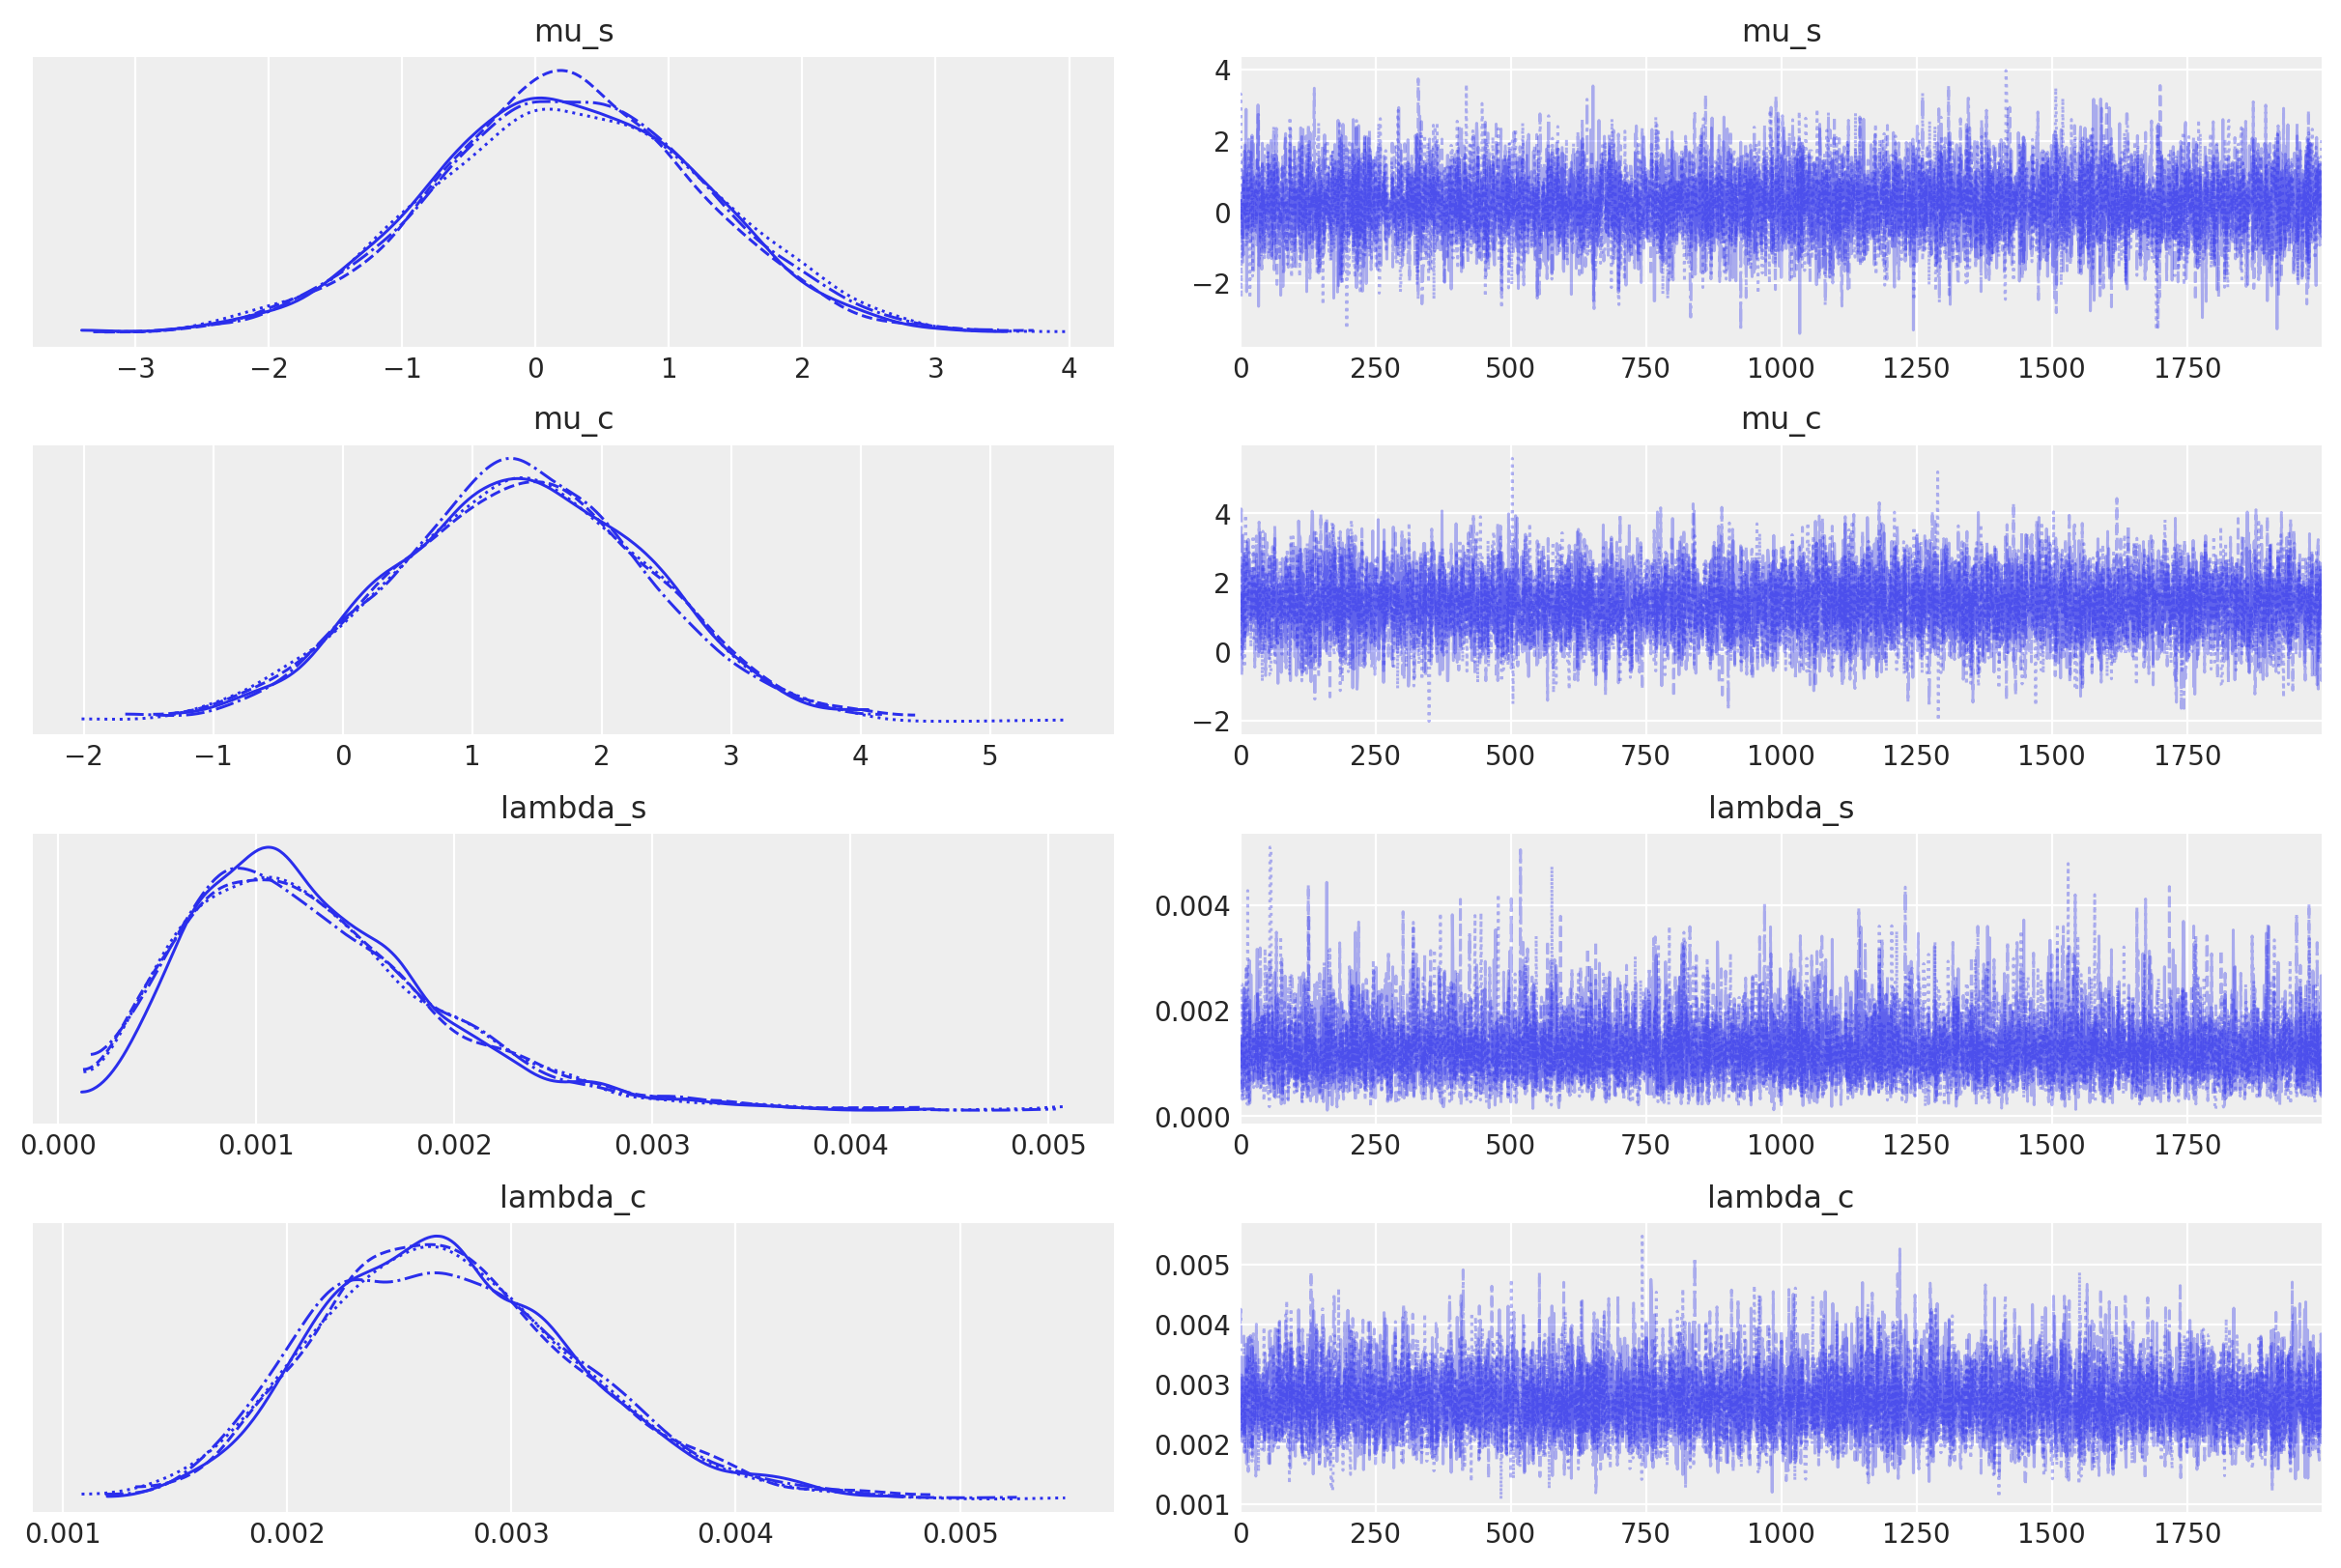

In [8]:
pm.traceplot(idata)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faa519933d0>,
      dtype=object)

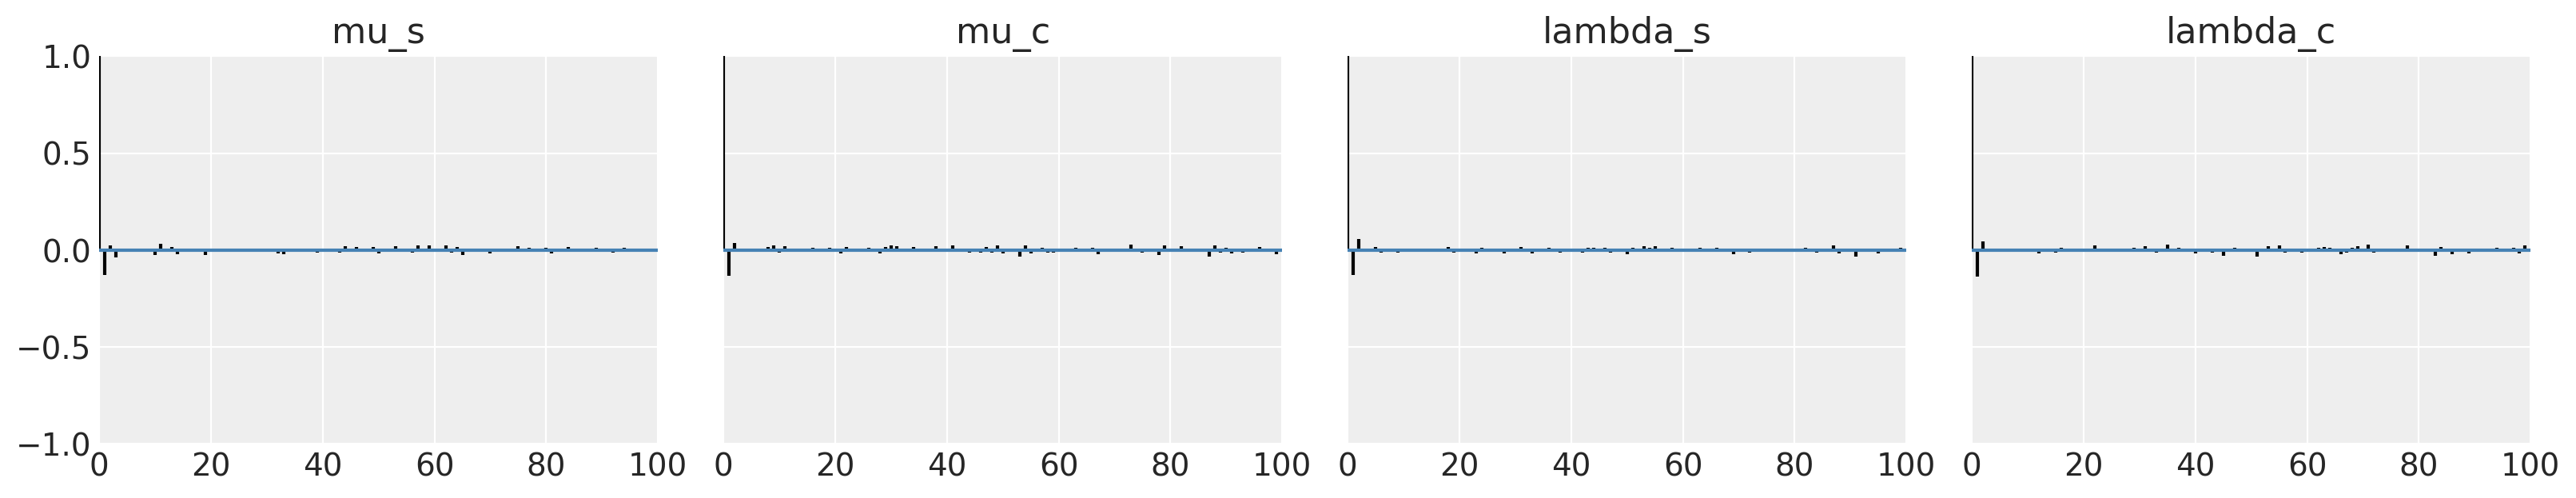

In [9]:
az.plot_autocorr(idata, combined=True, figsize=(16,3))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faa5186e9d0>]],
      dtype=object)

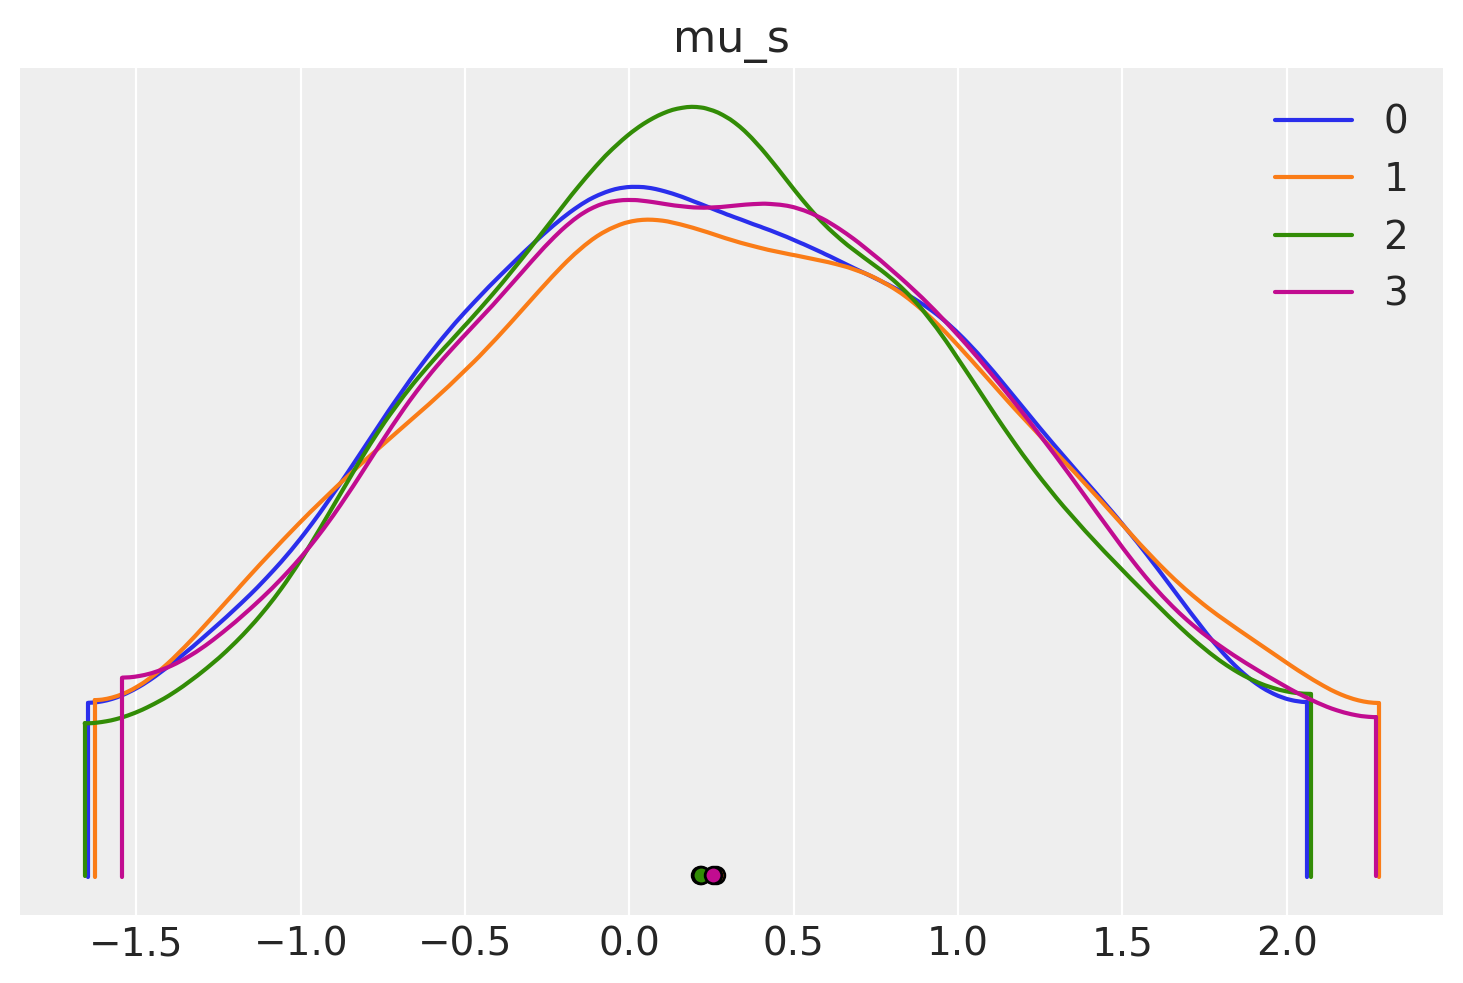

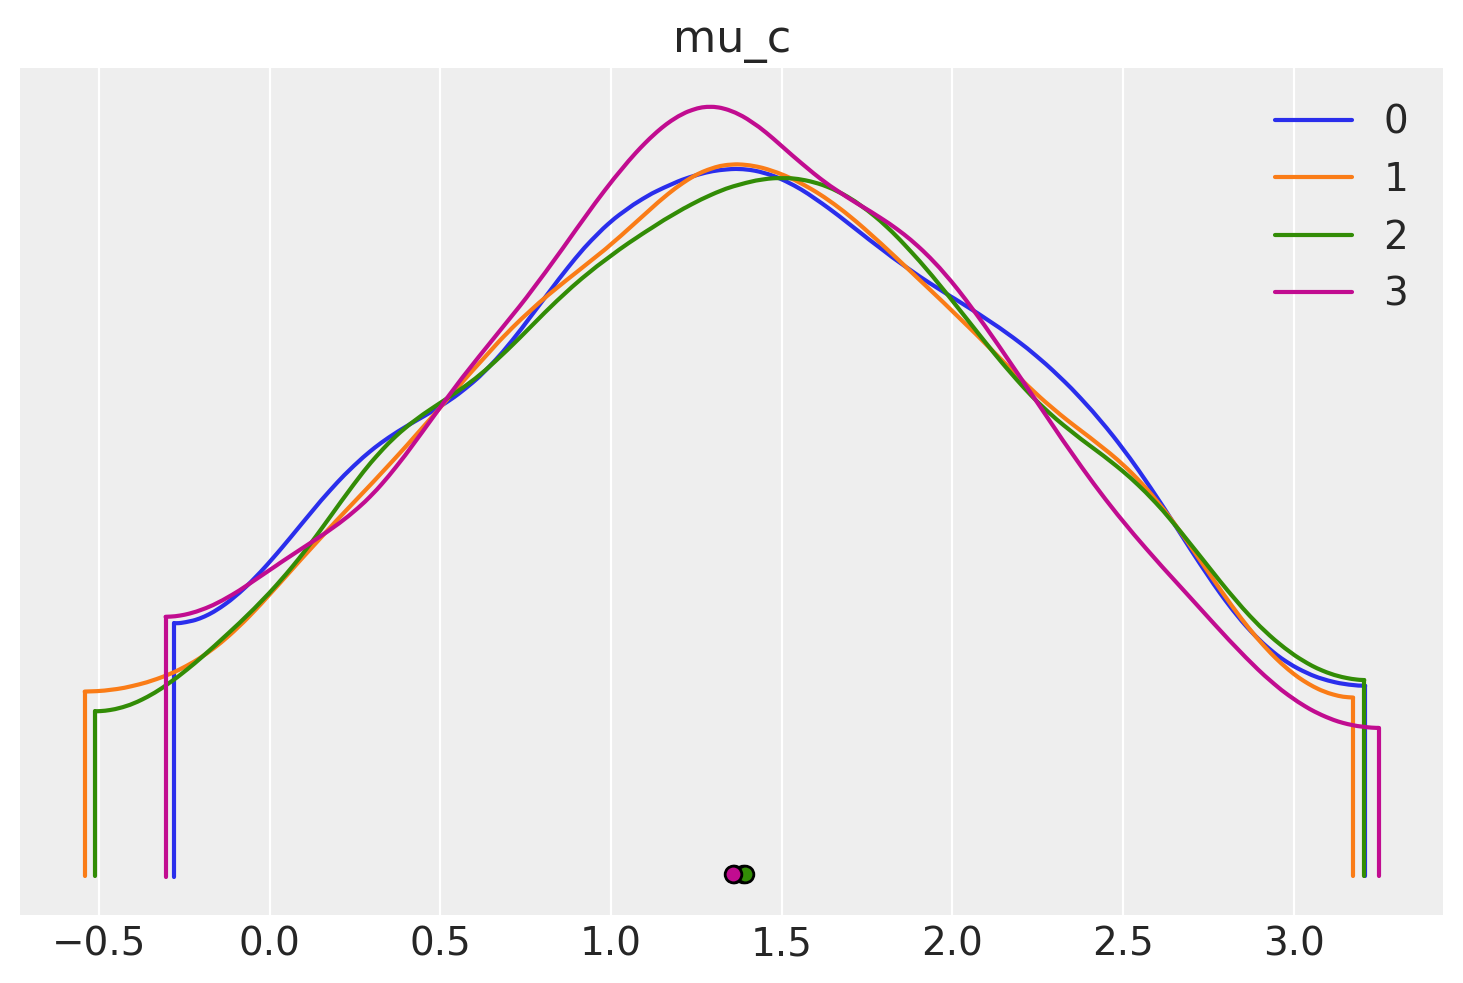

In [10]:
az.plot_density([c for c in idata.posterior.mu_s])
az.plot_density([c for c in idata.posterior.mu_c])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faa514d4950>]],
      dtype=object)

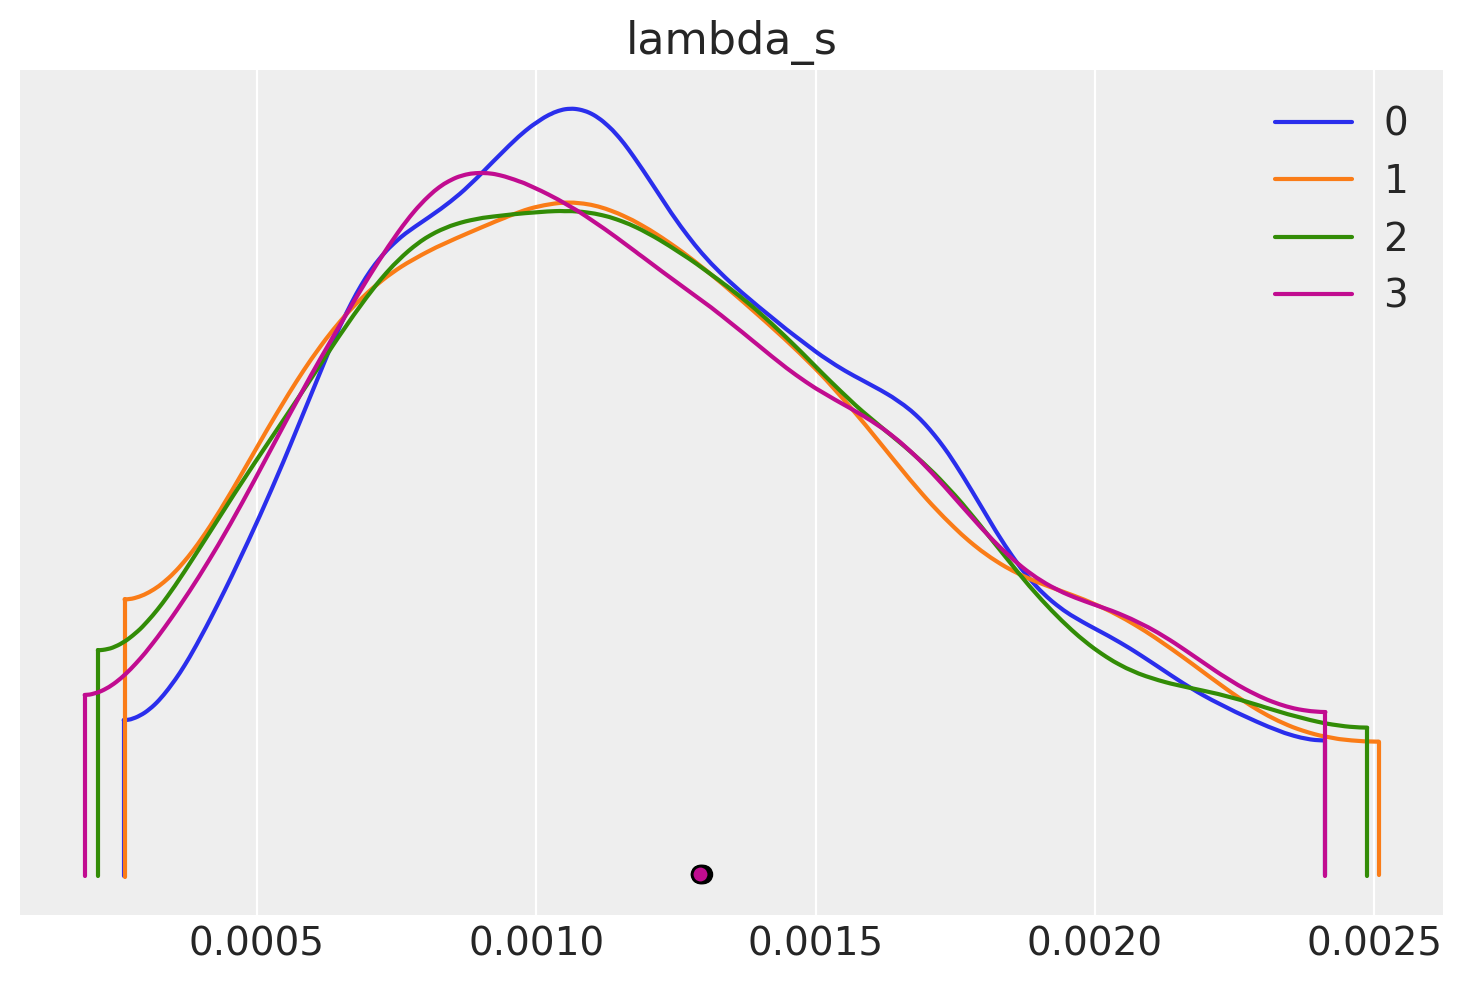

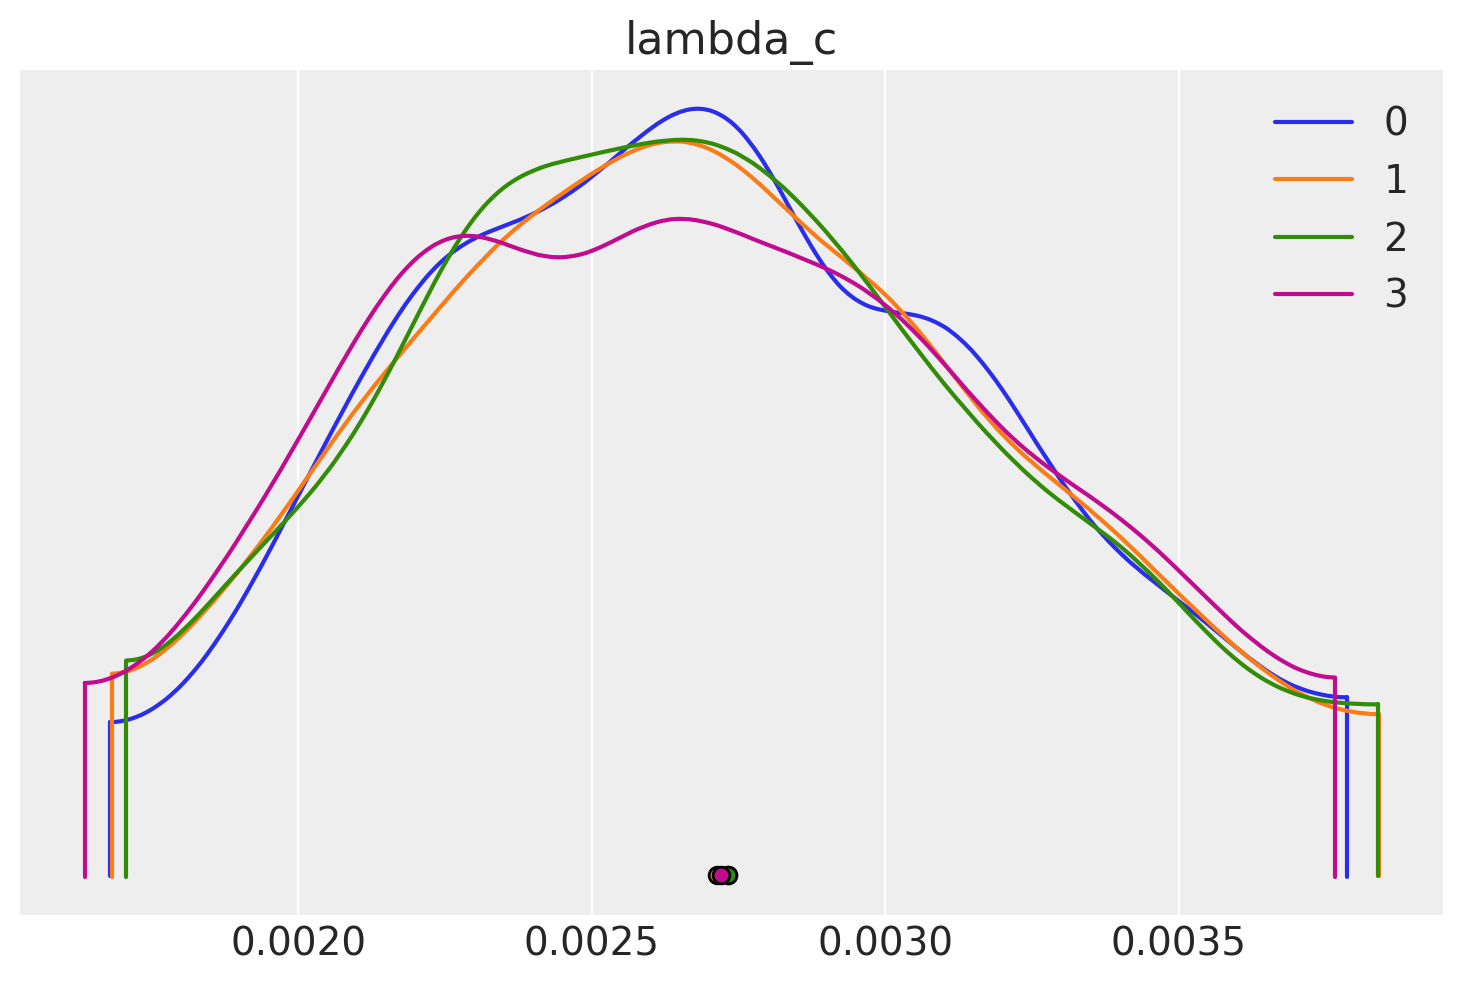

In [11]:
az.plot_density([c for c in idata.posterior.lambda_s])
az.plot_density([c for c in idata.posterior.lambda_c])

(-5.0, 5.0)

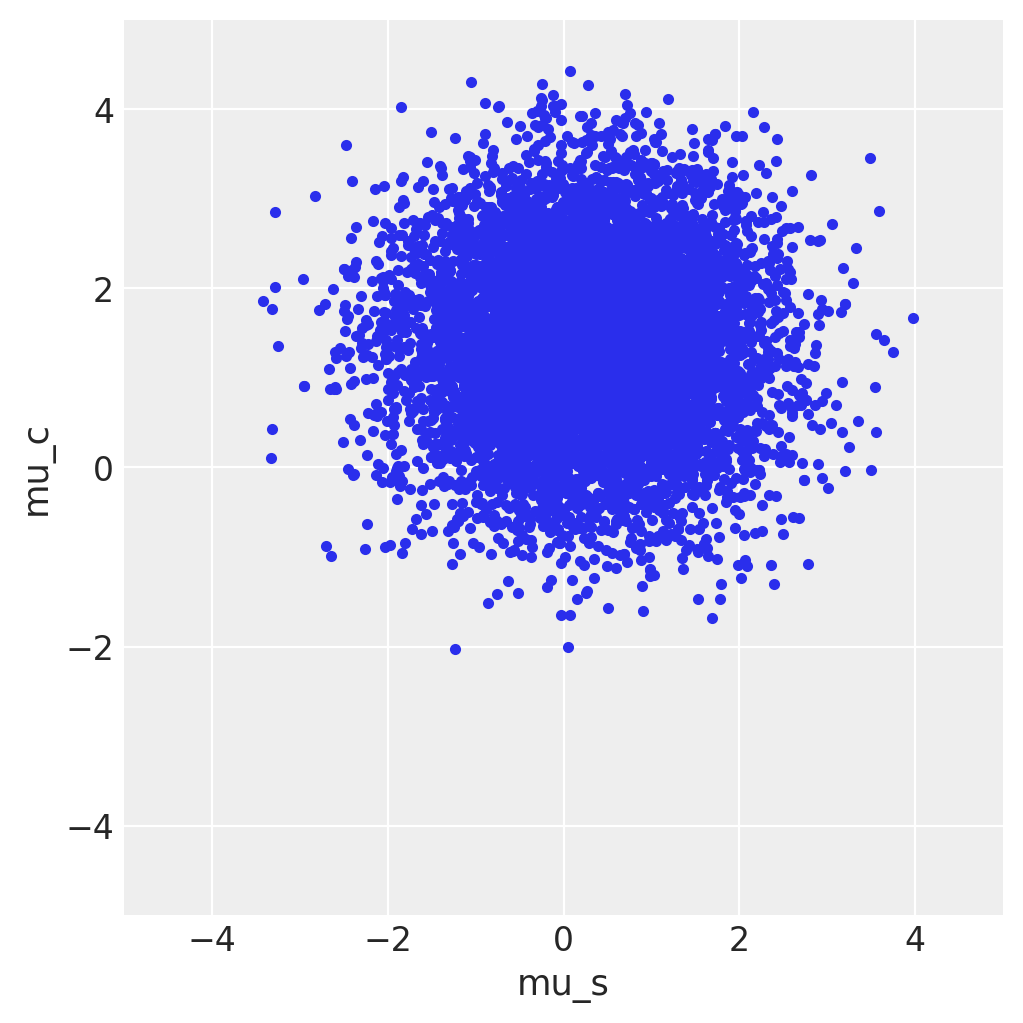

In [12]:
az.plot_pair(idata, var_names=['mu_s', 'mu_c'], figsize=(5,5))
plt.xlim(-5, 5)
plt.ylim(-5, 5)

In [13]:
(idata.posterior.mu_s > idata.posterior.mu_c).sum() / 8000

<xarray.DataArray ()>
array(0.211375)

* $\mu_s > \mu_c$の確率が0.211
 * 学生に期待をかけないほうがいい？

## 4.4 事前分布 (2)
* ハイパーパラメータの決め方を考え直す。

### 4.4.1 事前分布の平均パラメータ$\mu_0$の設定
* 平均パラメータ$\mu_0$は、観測データの平均値とする。
 * なぜなら、一定期間教育を受ければ、そもそもIQは増えるものであるから。
 * この意味で、$\mu_0 = 0$という設定は、そもそもおかしかった。
 * しかし、どのくらい増えるものかについて、観測データ以外に手がかりがない。
 * そのため、観測データの単純平均を使った。

In [14]:
np.array(x_s + x_c).mean()

14.0

### 4.4.2 事前分布の分散パラメータ$\sigma_0^2$の設定
* 標準偏差パラメータ$\sigma_0$は100ぐらいとする。
 * つまり、IQの変化量の平均がどのくらいバラつくかという不確かさについては、観測データに決めてもらう、ということ。

### 4.4.3 PyMC3によるモデルの実装

In [15]:
mu_0 = 14.0
sd_0 = 100.0
alpha = 0.5

model = pm.Model()

with model:
    lambda_s = pm.Gamma("lambda_s", alpha=alpha, beta=100*alpha)
    lambda_c = pm.Gamma("lambda_c", alpha=alpha, beta=100*alpha)
    mu_s = pm.Normal("mu_s", mu=mu_0, sigma=sd_0)
    mu_c = pm.Normal("mu_c", mu=mu_0, sigma=sd_0)
    obs_s = pm.Normal("obs_s", mu=mu_s, tau=lambda_s, observed=np.array(x_s))
    obs_c = pm.Normal("obs_c", mu=mu_c, tau=lambda_c, observed=np.array(x_c))

### 4.4.4 MCMCによるベイズ推論
* デフォルトのNUTSサンプラを使う。

In [16]:
with model:
    idata = pm.sample(2000, cores=len(SEED), return_inferencedata=True, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_c, mu_s, lambda_c, lambda_s]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.


### 4.4.5 サンプルのチェック

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faa513ce510>,
      dtype=object)

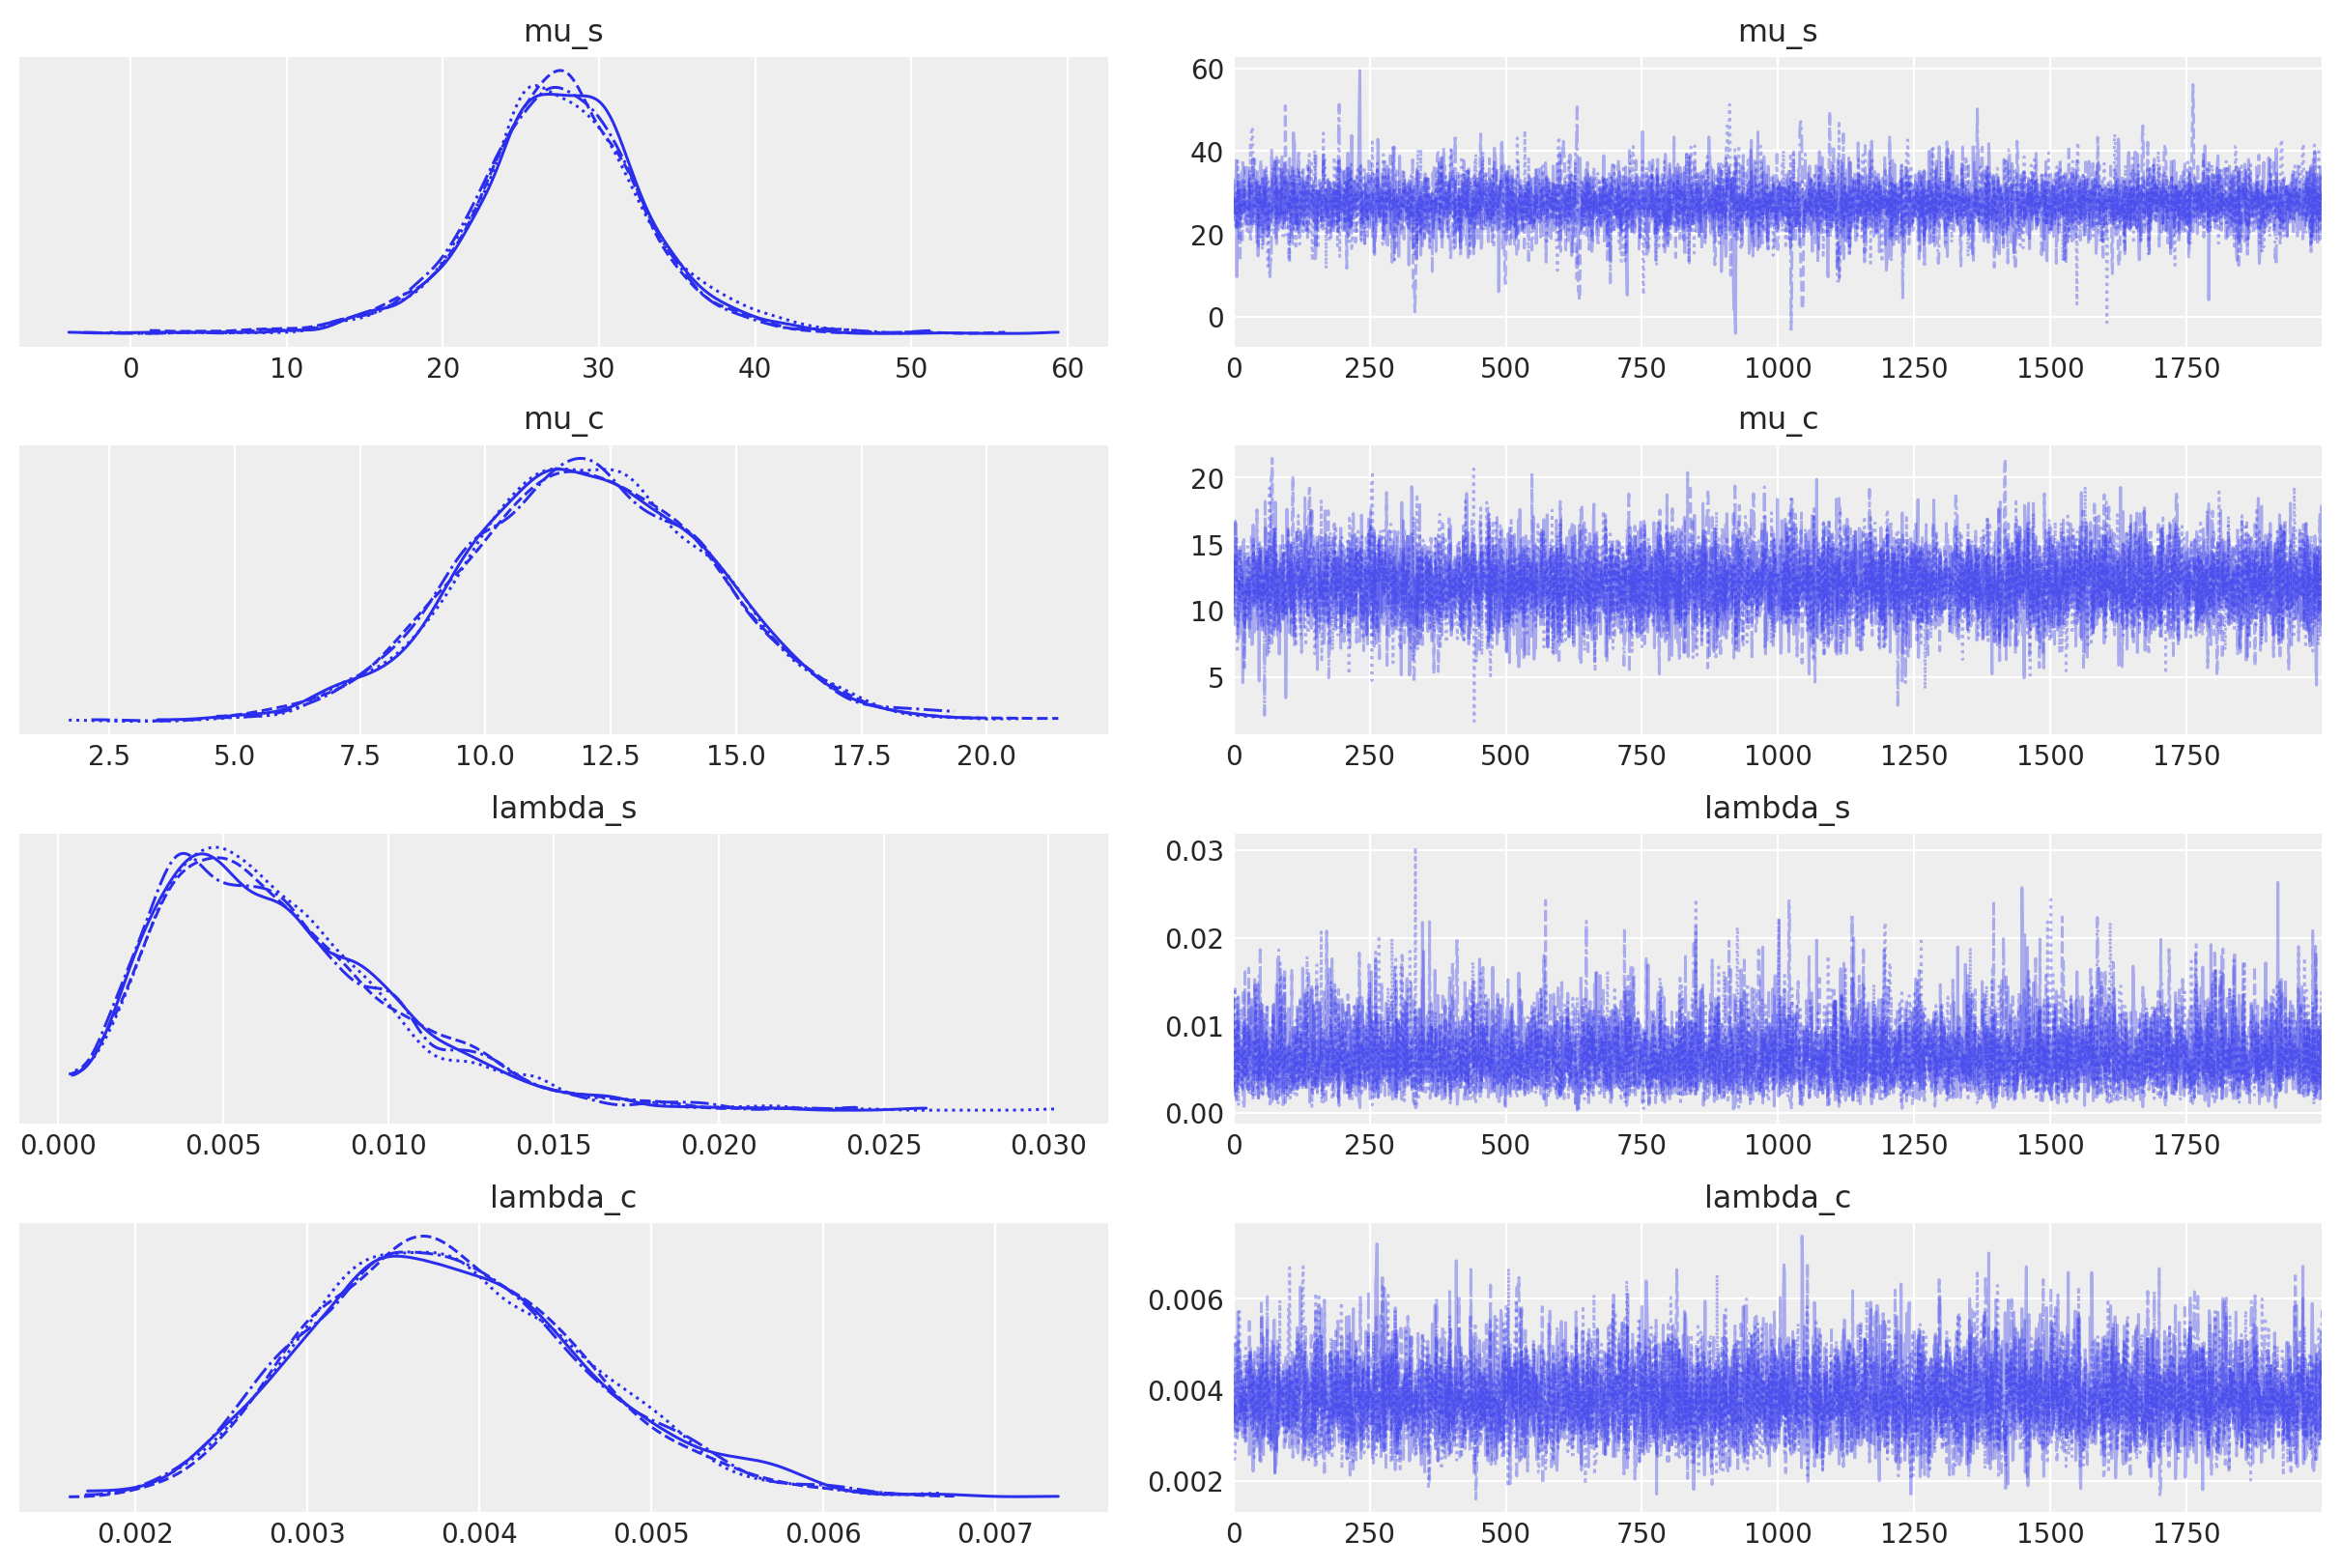

In [17]:
pm.traceplot(idata)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faa50d44e90>,
      dtype=object)

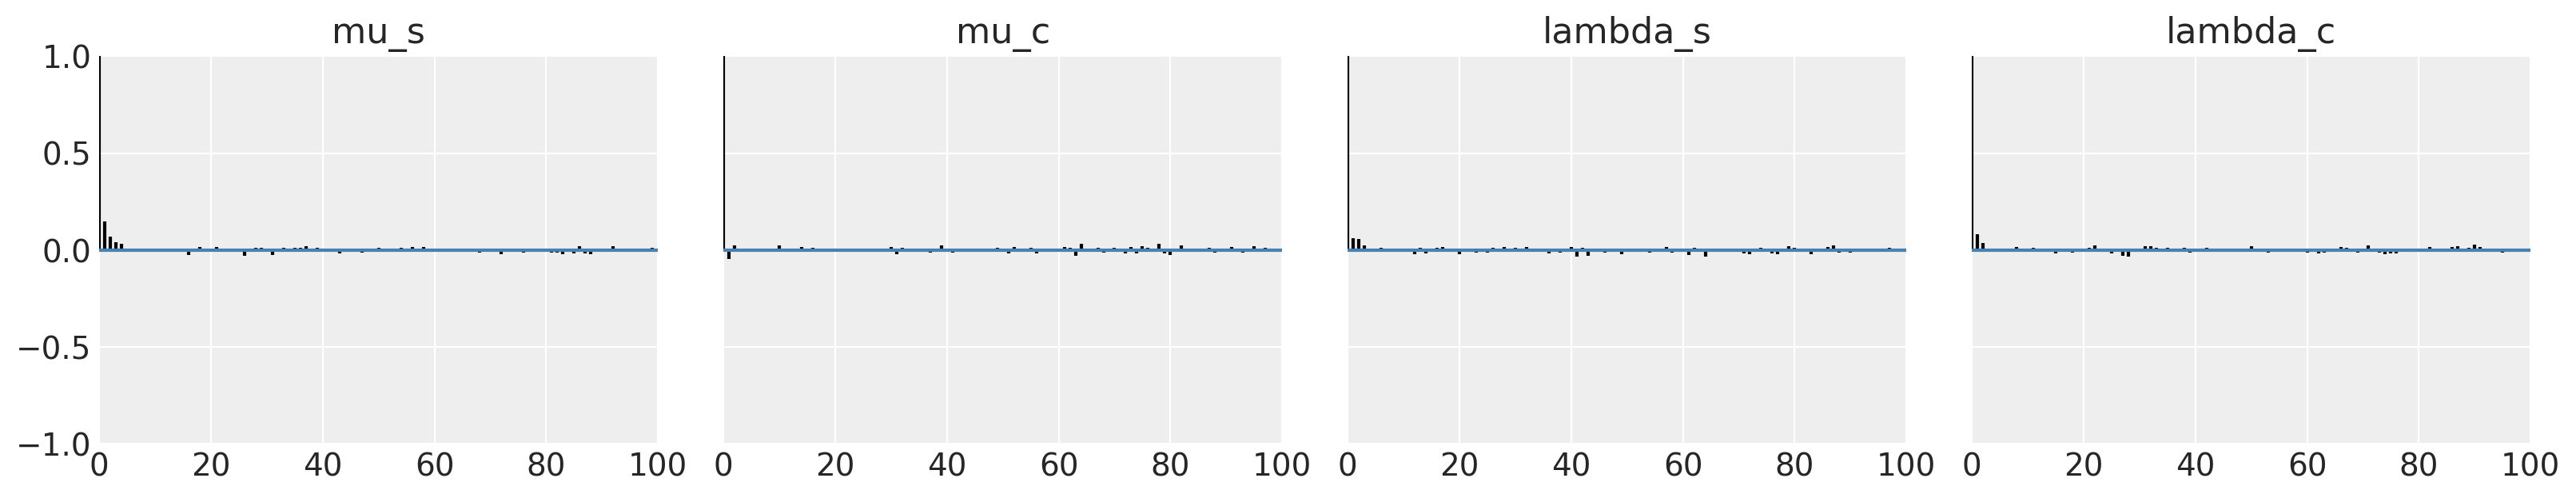

In [19]:
az.plot_autocorr(idata, combined=True, figsize=(16,3))

In [18]:
(idata.posterior.mu_s > idata.posterior.mu_c).sum() / 8000

<xarray.DataArray ()>
array(0.989375)

* 先ほどと真逆の結果。

## 4.5 課題
* あなたなら、どのように事前分布を決めるか？
* その決め方にしたがって分析をおこない、$\mathbb{P}(\mu_s > \mu_c | \mathbf{x}_s, \mathbf{x}_c)$を、上と同様にして求めよ。